In [79]:
from astropy.io import fits
import os
import warnings
import numpy as np
from scipy import ndimage
from astropy import units as u
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from numpy.polynomial import Polynomial

In [2]:
directory = '/Users/arcticfox/Documents/atmospheres/v1298tau/reduced/'

In [3]:
files = os.listdir(directory)
files = np.sort([os.path.join(directory,fn) for fn in files if fn.endswith('m.fits.bz2')])
#files = files[11:]

In [4]:
from pylab import *
colormap='viridis'

cmap = cm.get_cmap(colormap, len(files))
colors = []
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    colors.append(matplotlib.colors.rgb2hex(rgb))
colors = np.array(colors)

plt.rcParams['font.size'] = 18

In [5]:
hdu1 = fits.open(files[9])
hdu2 = fits.open(files[10])
quality_pre  = np.zeros(35, dtype=np.ndarray)
quality_post = np.zeros(35, dtype=np.ndarray)

length=0
rounding = 3

for i, o in enumerate(np.unique(hdu1[0].data[0])):
    q1 = hdu1[0].data[0] == o
    q2 = hdu2[0].data[0] == o
    
    w1 = hdu1[0].data[4][q1]
    w2 = hdu2[0].data[4][q2]
    
    if w1[0] > w2[0]:
        start = np.round(w1[0],rounding)
    else:
        start = np.round(w2[0],rounding)
        
    if w1[-1] > w2[-1]:
        end = np.round(w2[-1],rounding)
    else:
        end = np.round(w1[-1],rounding)
        
    q1_new = np.where( (w1 >= start) & (w1 <= end))[0]
    q2_new = np.where( (w2 >= start) & (w2 <= end))[0]
    if len(q1_new) != len(q2_new):
        if len(q1_new)-len(q2_new) == 1:
            q1_new = q1_new[1:]
        elif len(q1_new)-len(q2_new) == -1:
            q2_new = q2_new[:-1]
        elif len(q1_new)-len(q2_new) == -2:
            q2_new = q2_new[1:-1]
            
    quality_pre[i]  = q1_new
    quality_post[i] = q2_new
        
    length += len(q1_new)
hdu1.close()
hdu2.close()

In [190]:
def sliding_kernel(w, f, window=21, percentile=99):
    steps = np.arange(0,len(f)+window,window,dtype=int)
    steps[-1] = len(f)-1
    y = np.zeros(len(steps))
    
    for i in range(len(steps)-1):
        start = int(steps[i])
        end   = int(steps[i+1])
        y[i] = np.nanpercentile(f[start:end], percentile)
        if percentile==100:
            y[i] = np.nanmax(f[start:end])
            
    y[-1] = np.nanpercentile(f[steps[-2]:], percentile)
    if percentile==100:
        y[-1] = np.nanmax(f[steps[-2]:])
    
    interp = interp1d(w[steps], y)
    return interp(w)

#######################################################

def remove_blaze(w, f, window=105, percentile=99, deg=None):
    y = sliding_kernel(w, f, window=window, percentile=percentile)
    if deg is not None:
        fit = Polynomial.fit(w, y, deg=deg)
        y   = fit(w)
    removed = f / y 
    normalized = removed/np.nanmedian(removed)
    return normalized, y

In [206]:
ORDERS = np.zeros(len(files), dtype=np.ndarray)
WAVELENGTH = np.zeros(len(files), dtype=np.ndarray)
NORMFLUX = np.zeros(len(files), dtype=np.ndarray)
DATES =  np.zeros(len(files))

for i,fn in enumerate(files):
    newname = files[i][:-9] + '.npy'
    hdu = fits.open(fn)
    
    blaze_corr = np.array([])
    wave  = np.array([])
    order = np.array([])

    for j in range(len(np.unique(hdu[0].data[0]))):
    #for j in range(20,21):
        unique_order = np.unique(hdu[0].data[0])[j]
        o = hdu[0].data[0] == unique_order

        w = hdu[0].data[4][o]
        f = hdu[0].data[8][o]/np.nanmedian(hdu[0].data[8][o])


        # artisinal work on a filter to try and get a x-corr that looks gaussian
        # then figure out a way to make it "corporate" to all orders
        # might be over interpolating?
        normalized0, fit0 = remove_blaze(w, f, window=155, percentile=100, deg=9)
        normalized1, fit1 = remove_blaze(w, normalized0, window=105, percentile=100, deg=3)
        normalized, fit2  = remove_blaze(w, normalized1, window=255, percentile=98)#, deg=2)

        w = w
        normalized = normalized
        
        ## interpolation that should be removed later
       # redstart = w[0]
       # blueend = w[-1]
       # factor = 6

       # qtemp = hdu[0].data[0] == o
       # finer_wavelength = np.logspace(log10(redstart), log10(blueend),
       #                                len(w)*factor, base=10.0)

       # finer_wavelength[0]=redstart
       # finer_wavelength[-1]=blueend
        
        func = interp1d(w, normalized)
       # n = func(finer_wavelength)
    
        ## homemade max window fitter thingy
       # corr = np.correlate(n - np.nanmean(n), 
       #                     n - np.nanmean(n), 
       #                     mode='same')
       # corr_window = 25
        
       # c = np.arange(np.argmax(corr)-corr_window, 
       #               np.argmax(corr)+corr_window,
       #               1,dtype=int)
        
        
       # fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(18,3))
        #plt.plot(wave, f, 'k')
       # ax1.set_title(unique_order)
       # ax1.plot(w, f[350:-500], 'k')
       # ax1.plot(w, fit0[350:-500], 'w')
        
       # ax2.plot(w, normalized0[350:-500], 'k')
       # ax2.plot(w, fit1[350:-500], 'w')
        
       # ax3.plot(w, normalized1[350:-500], 'k')
       # ax3.plot(w, fit2[350:-500], 'w')
       # ax3.plot(finer_wavelength, n, 'r', linewidth=1)

       # ax4.plot(finer_wavelength[c], corr[c], 'w.')
        #plt.ylim(0,2)
       # plt.show()
        
        wave  = np.append(wave, w)
        order = np.append(order, hdu[0].data[0][o])
        blaze_corr = np.append(blaze_corr, normalized)
        
    ## CUT BITS OFF FROM EITHER END ITS FINE
    WAVELENGTH[i] = wave
    ORDERS[i] = order
    NORMFLUX[i] = blaze_corr
    
    if hdu[0].header['EREADSPD'] == 'Normal: 4.15e noise, 1.30e/ADU, 19s':
        if hdu[0].header['OBSTYPE'] == 'OBJECT':
            DATES[i] = hdu[0].header['MJDATE']
                
    np.save(newname, np.array([ORDERS[i], WAVELENGTH[i], NORMFLUX[i]]))
    print(fn)
    hdu.close()

/Users/arcticfox/Documents/atmospheres/v1298tau/reduced/N20200122G0038m.fits.bz2
/Users/arcticfox/Documents/atmospheres/v1298tau/reduced/N20200122G0039m.fits.bz2
/Users/arcticfox/Documents/atmospheres/v1298tau/reduced/N20200122G0040m.fits.bz2
/Users/arcticfox/Documents/atmospheres/v1298tau/reduced/N20200122G0041m.fits.bz2
/Users/arcticfox/Documents/atmospheres/v1298tau/reduced/N20200122G0042m.fits.bz2
/Users/arcticfox/Documents/atmospheres/v1298tau/reduced/N20200122G0043m.fits.bz2
/Users/arcticfox/Documents/atmospheres/v1298tau/reduced/N20200122G0044m.fits.bz2
/Users/arcticfox/Documents/atmospheres/v1298tau/reduced/N20200122G0045m.fits.bz2
/Users/arcticfox/Documents/atmospheres/v1298tau/reduced/N20200122G0046m.fits.bz2
/Users/arcticfox/Documents/atmospheres/v1298tau/reduced/N20200122G0047m.fits.bz2
/Users/arcticfox/Documents/atmospheres/v1298tau/reduced/N20200122G0048m.fits.bz2
/Users/arcticfox/Documents/atmospheres/v1298tau/reduced/N20200122G0049m.fits.bz2
/Users/arcticfox/Documents/a

(0.5, 1.1)

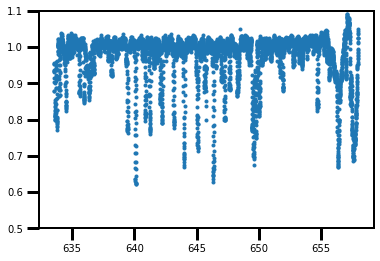

In [210]:
q = ORDERS[0] == 35
plt.plot(WAVELENGTH[0][q], NORMFLUX[0][q], '.')
#plt.plot(INTERPOLATED_WAVELENGTH[0], INTERPOLATED_SPECTRA[0], '.')
plt.ylim(0.5,1.1)
#plt.xlim(655.9,656.6)

In [211]:
from astropy.time import Time
dates = Time(DATES, format='mjd').jd
dates

array([2458870.725, 2458870.73 , 2458870.734, 2458870.739, 2458870.744,
       2458870.748, 2458870.753, 2458870.758, 2458870.762, 2458870.767,
       2458870.778, 2458870.782, 2458870.787, 2458870.791, 2458870.796,
       2458870.801, 2458870.805, 2458870.81 , 2458870.815, 2458870.819,
       2458870.824, 2458870.829, 2458870.833, 2458870.838, 2458870.843,
       2458870.847, 2458870.852, 2458870.857, 2458870.861, 2458870.866,
       2458870.871, 2458870.875, 2458870.88 , 2458870.885, 2458870.889,
       2458870.894, 2458870.899, 2458870.903, 2458870.908, 2458870.913,
       2458870.917, 2458870.922, 2458870.927, 2458870.931, 2458870.936,
       2458870.941, 2458870.945, 2458870.95 , 2458870.955, 2458870.959,
       2458870.964, 2458870.969, 2458870.973])

In [212]:
WAVELENGTH.shape

(53,)

In [213]:
OUT = np.where( dates>2458870.941)[0]
BOTH = np.where(dates<=2458870.762)[0]
BOTH

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [214]:
np.save('1d_wavelength.npy', WAVELENGTH)
np.save('1d_spectra.npy', NORMFLUX)
np.save('1d_orders.npy', ORDERS)

## Checking spectra

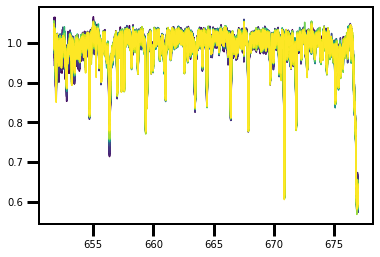

In [215]:
order = 34
fig, ax = plt.subplots()
for i in range(len(NORMFLUX)):
    plt.plot(WAVELENGTH[i][ORDERS[i]==order],
            NORMFLUX[i][ORDERS[i]==order], c=colors[i])
ax.set_facecolor('w')
plt.show()

## Getting the interpolation start & end points

In [216]:
start_end = np.zeros((len(np.unique(ORDERS[0])), 2))

for o in range(len(np.unique(ORDERS[0]))):
    temp_start = np.zeros(len(WAVELENGTH))
    temp_stop  = np.zeros(len(WAVELENGTH))
    order = np.unique(ORDERS[0])[o]
    
    for i in range(len(WAVELENGTH)):
        q = ORDERS[i] == int(order)
        temp_start[i] = WAVELENGTH[i][q][0]
        temp_stop[i]  = WAVELENGTH[i][q][-1]
        
    start_end[o][0] = np.nanmax(temp_start)
    start_end[o][1] = np.nanmin(temp_stop)

## Interpolating Wavelengths

In [217]:
def grid_wavelength(wavelength, spectra, orders, factor):
    global WAVELENGTH, ORDERS
#    interp_waves = np.zeros(len(wavelength))#, wavelength.shape[1]*factor))
#    interp_spect = np.zeros(len(spectra))#, spectra.shape[1]*factor))   

    unique_orders = np.unique(orders)
    interp_waves = np.array([])
    interp_spect = np.array([])
    interp_orders = np.array([])
    
    for i, o in enumerate(unique_orders):
        q = orders == o
        redstart = start_end[i][0]
        blueend = start_end[i][1]

        qtemp = ORDERS[0] == o
        finer_wavelength = np.logspace(log10(redstart), log10(blueend),
                                       len(WAVELENGTH[0][qtemp])*factor, base=10.0)

        finer_wavelength[0]=redstart
        finer_wavelength[-1]=blueend
        
        f = interp1d(wavelength[q], spectra[q])
        interp_spect = np.append(interp_spect, f(finer_wavelength))
        interp_waves = np.append(interp_waves, finer_wavelength)
        interp_orders = np.append(interp_orders, np.full(len(finer_wavelength), o))
    
    return interp_waves, interp_spect, interp_orders

In [218]:
FACTOR = 3

INTERPOLATED_WAVELENGTH = np.zeros( (len(WAVELENGTH), 582945) )
INTERPOLATED_SPECTRA    = np.zeros( (len(WAVELENGTH), 582945) )
INTERPOLATED_ORDERS     = np.zeros( (len(WAVELENGTH), 582945) )

for i in range(len(WAVELENGTH)):
    iw, iss, io = grid_wavelength(WAVELENGTH[i], NORMFLUX[i], ORDERS[i], FACTOR)
    INTERPOLATED_WAVELENGTH[i] = iw
    INTERPOLATED_SPECTRA[i] = iss
    INTERPOLATED_ORDERS[i] = io

(0.8, 1.1)

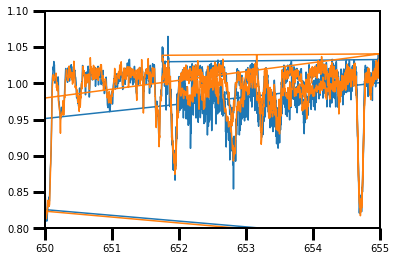

In [219]:
plt.plot(INTERPOLATED_WAVELENGTH[0], INTERPOLATED_SPECTRA[0])
plt.plot(INTERPOLATED_WAVELENGTH[15], INTERPOLATED_SPECTRA[15])
plt.xlim(650,655)
plt.ylim(0.8,1.1)

## Stellar RV

In [220]:
star_bc = 16.15 * u.km / u.s
speedlight = 2.998e8 * u.m / u.s
dopshift = ((INTERPOLATED_WAVELENGTH*u.nm * star_bc) / speedlight).to(u.nm)
INTERPOLATED_WAVELENGTH = (INTERPOLATED_WAVELENGTH*u.nm - dopshift).to(u.nm).value

In [221]:
INTERPOLATED_ORDERS.shape

(53, 582945)

In [222]:
np.save('interp_1d_wavelength.npy', INTERPOLATED_WAVELENGTH)
np.save('interp_1d_spectra.npy', INTERPOLATED_SPECTRA)
np.save('interp_1d_orders.npy', INTERPOLATED_ORDERS)

In [223]:
np.where(WAVELENGTH[0]>=514.8838)[0][-1]

140257

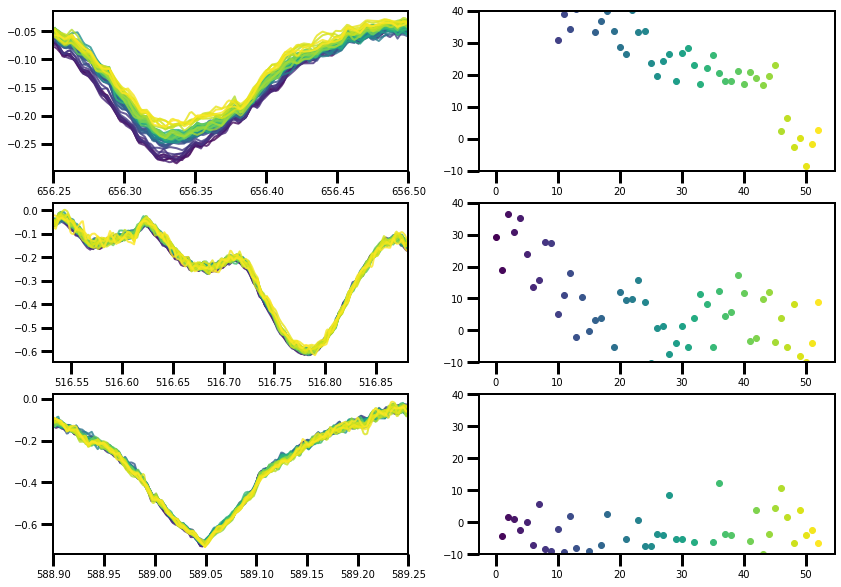

In [224]:
fig, ((ax1,ax2), (ax3,ax4), (ax5,ax6)) = plt.subplots(ncols=2, nrows=3, figsize=(14,10))
new_feature=[656.35, 516.7322, 589.1]
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

feature = 0
for count in [0,2,4]:
    ax1 = axes[count]
    ax2 = axes[count+1]
    for i in range(len(INTERPOLATED_ORDERS)):
        if count == 0:
            order = 34
            bounds = [0.1,0.15]
           #ax1.set_ylim(-0.3,0)
        else:
            lim = np.where(INTERPOLATED_WAVELENGTH[i] >= new_feature[feature])[0][-1]
            order = int(INTERPOLATED_ORDERS[i][lim])
            bounds = [0.2, 0.15]
        
        q = ((INTERPOLATED_ORDERS[i] == order) & 
             (INTERPOLATED_WAVELENGTH[i] >= new_feature[feature]-bounds[0]) & 
             (INTERPOLATED_WAVELENGTH[i] <= new_feature[feature]+bounds[1]))

        flux = INTERPOLATED_SPECTRA[i][q] - 1
        wave = INTERPOLATED_WAVELENGTH[i][q]
        template = np.nanmedian(INTERPOLATED_SPECTRA[OUT], axis=0)[q] - 1
        
        ax1.plot(wave, flux, alpha=0.8, c=colors[i], lw=2)

        ax1.set_xlim(new_feature[feature]-bounds[0],new_feature[feature]+bounds[1])
        
        try:
            ax2.plot(i, np.nansum( (flux[1:]/template) - 1 ) , 'o',c=colors[i])
        except:
            ax2.plot(i, np.nansum( (flux/template) - 1 ) , 'o',c=colors[i])
#        print(np.nansum( (flux/template) - 1 ))
        ax2.set_ylim(-10,40)
    feature += 1
#ax1.set_xlabel('Wavelength [nm]')
#ax2.set_xlabel('Wavelength [nm]')
#ax1.set_ylabel('Normalized Flux')
#ax2.set_title('Sodium')
#plt.savefig('/Users/arcticfox/Desktop/hooray.png', dpi=250, rasterize=True,
#           bbox_inches='tight')

In [225]:
np.save('1d_orders.npy', ORDERS)
np.save('1d_wavelength.npy', WAVELENGTH)
np.save('1d_spectra.npy', NORMFLUX)
np.save('mjddates.npy', DATES)

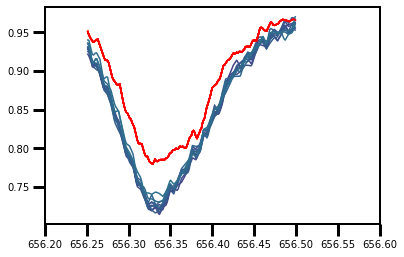

In [226]:
#plt.plot(np.arange(0,1000,10), np.arange(0,1000,10), 'r')
order = 34
bounds = [0.1,0.15]

for i in range(len(BOTH)+1):
    
    q = ((INTERPOLATED_ORDERS[i] == order) & 
         (INTERPOLATED_WAVELENGTH[i] >= 656.35-bounds[0]) & 
         (INTERPOLATED_WAVELENGTH[i] <= 656.35+bounds[1]))
    template_s = np.nanmedian(INTERPOLATED_SPECTRA[OUT], axis=0)[q]
    template_w = np.nanmedian(INTERPOLATED_WAVELENGTH[OUT], axis=0)[q]
    plt.plot(template_w, template_s, 'r')
    plt.plot(INTERPOLATED_WAVELENGTH[i][q], INTERPOLATED_SPECTRA[i][q], c=colors[i+10])

plt.xlim(656.2, 656.6)
#plt.ylim(656.2, 656.5)
plt.show()